In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    # + on 25/07/2016

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def cum_var(evals0, silent=True, verbose=False):
    '''
    Determines the cumulative variance percentage from the eigenvalues
    Parameters
    ----------
    evals0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    silent : boolean
          Turns off stdout messages. Default: True
    verbose : boolean
          Turns on additional stdout messages. Default: False
	  
    Returns
    -------
    cum_var0 : array like
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    tot      = sum(evals0)
    var0     = [(ii / tot)*100 for ii in sorted(evals0, reverse=True)]
    cum_var0 = np.cumsum(var0)

    return cum_var0
#enddef

def pca_str(evec, cum_var0=None, label_sample=None, silent=True, verbose=False):
    '''
    Construct string of PCA components to annotate plots
    Parameters
    ----------
    evec : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    cum_var0 : array like, optional
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    
    label_sample : string, optional. Default: None
      Bibliographical label for points that are plotted
    silent : boolean, optional. Default: True
          Turns off stdout messages. 
    verbose : boolean, optional. Default: False
          Turns on additional stdout messages. 
	  
    Returns
    -------
    PCA_str : string
      Raw string returned. LaTeX-formatted
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    n_vec = evec.shape[0]

    if n_vec == 2:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[0][0], evec[0][1])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[1][0], evec[1][1])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
        PCA_str  = PCA_str1+'\n'+PCA_str2
    
    if n_vec == 3:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[0][0], evec[0][1],
                                                                      evec[0][2])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[1][0], evec[1][1],
                                                                      evec[1][2])
        PCA_str3 = r'PC$_3$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[2][0], evec[2][1],
                                                                      evec[2][2])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
            PCA_str2 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[1])

        PCA_str = PCA_str1+'\n'+PCA_str2+'\n'+PCA_str3

    # Mod on 02/08/2016
    if label_sample != None:
        PCA_str = " + ".join(label_sample)+'\n'+PCA_str

    return PCA_str
#enddef


In [3]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

# %matplotlib inline
# %matplotlib qt
# %matplotlib notebook

In [4]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])


# defining useful data structs for plotting
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
markarr = np.array(['o', 'o', '^', 'D', '*'])

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7046.0, 7111.0, 8150.0, 9196.0, 9755.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S4')
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])

# defining a flux sigma cutoff
good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]

# title = 'mainseq_filt_nii_dust_corrs'
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

xarr = stlr_mass[good_sig_iis]
yarr = obs_sfr[good_sig_iis]+corrs[good_sig_iis]
zarr = zspec0[good_sig_iis]

ffs = filts[good_sig_iis]

In [5]:
badz_iis = np.array([x for x in range(len(zarr)) if zarr[x] < 0 or zarr[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

In [6]:
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zarr[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1

In [7]:
labels = ['log[M]', 'z', 'SFR']

xData = np.copy(xarr)
yData = np.copy(zarr)
zData = np.copy(yarr)

n_sample = len(xData)

In [8]:
xData0 = np.reshape(xData, (len(xData),1))
yData0 = np.reshape(yData, (len(yData),1))
zData0 = np.reshape(zData, (len(zData),1))

In [9]:
data = np.hstack((xData0, yData0, zData0))

In [10]:
mu = data.mean(axis=0)
print '## mean : ', mu

## mean :  [ 8.11685323  0.33330504 -1.21919147]


In [11]:
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

In [12]:
# for ii in range(n_sample):
#     x1 = np.reshape(xData[ii], (len(xData[ii]),1))
#     y1 = np.reshape(yData[ii], (len(yData[ii]),1))
#     z1 = np.reshape(zData[ii], (len(zData[ii]),1))
#     t_data = np.hstack((x1,y1,z1))
#     temp  = np.dot(t_data, evec)
#     if ii == 0:
#         projected_data = [temp]
#     else: projected_data.append(temp)

In [13]:
# plot_3d(xData, yData, zData, evec, mu, sigma, labels, out_pdf='temp_out.pdf',
#         ref_name0=None, cum_var0=cum_var0, silent=False,
#         verbose=True, animate=False, label_sample=None,
#         proposal=False)

In [14]:
evec

array([[-0.72556893,  0.68808842, -0.00916768],
       [-0.08420532, -0.10199836, -0.99121431],
       [-0.68297817, -0.71842234,  0.13194755]])

In [15]:
cum_var0

array([  76.15999752,   95.61423512,  100.        ])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


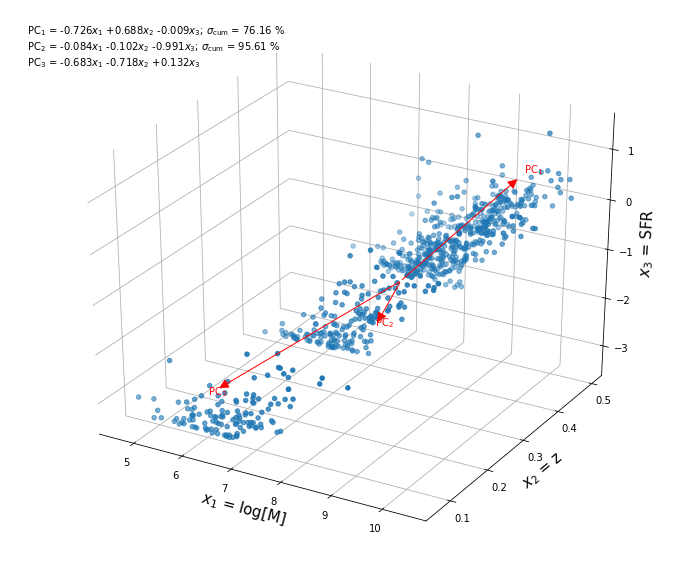

In [16]:
from mpl_toolkits.mplot3d import Axes3D, proj3d

fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xData, yData, zData)
ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='15')
ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='15')
ax.set_zlabel(r'$x_3$ = '+labels[2], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
    zd = [mu[2], mu[2] + sigma * axis[2]]

    a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
                color="r")
    ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
    zt = mu[2] + 1.05 * sigma * axis[2]
    ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')


for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.gridlines.set_linestyle('dashed')
    axis.set_pane_color((1,1,1,1)) # White background
    axis.gridlines.set_color((0,0,0,1)) # Black grid

In [17]:
%matplotlib inline

## mean :  [ 8.11685323 -1.21919147]
[[-0.72854698 -0.68499584]
 [-0.68499584  0.72854698]]
[  79.6770017  100.       ]


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


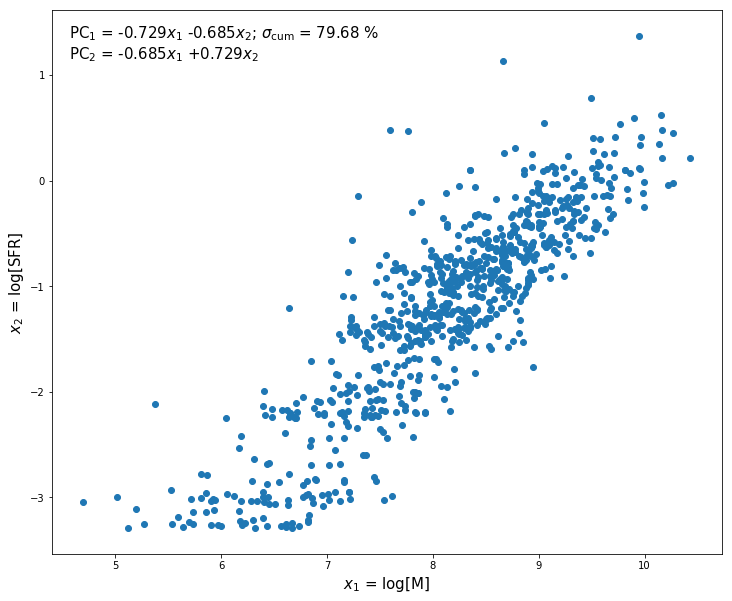

In [18]:
n_sample = len(xarr)
labels = ['log[M]', 'log[SFR]']

xData = np.copy(xarr) # log[M]
zData = np.copy(yarr) # log[SFR]

xData0 = np.reshape(xData, (len(xData),1))
zData0 = np.reshape(zData, (len(zData),1))

data = np.hstack((xData0, zData0))
mu = data.mean(axis=0)
print '## mean : ', mu
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

print evec
print cum_var0

# fig, ax = plt.figure()
# fig.set_size_inches(12,10)

plt.scatter(xData, zData)
plt.xlabel(r'$x_1$ = '+labels[0], fontsize='15')
plt.ylabel(r'$x_2$ = '+labels[1], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
#     zd = [mu[2], mu[2] + sigma * axis[2]]

#     a = Arrow3D(xd, yd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")

#     a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")
#     ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
#     zt = mu[2] + 1.05 * sigma * axis[2]
#     ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

plt.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top', fontsize=15)

plt.gcf().set_size_inches(12,10)

In [21]:
# def pca_2d_fit(m):
#     return 0.673/0.739*m

# plt.plot(smass0, sfrs00, 'o')
# plt.plot(smass0, pca_2d_fit(smass0))

In [22]:
# compute median of galaxies in PCA space to get intercept

In [23]:
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])

In [24]:
len(np.where(stlr_mass==-1.0)[0])

211

In [25]:
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

In [26]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])

fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])

filts = np.array(corr_tbl['filt'])

# defining a flux sigma cutoff
good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]

obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

ffs = filts[good_sig_iis]

zspec0 = np.array(corr_tbl['zspec0'])[good_sig_iis]
smass0 = stlr_mass[corr_tbl['ID'].data-1][good_sig_iis]

badz_iis = np.array([x for x in range(len(zspec0)) if zspec0[x] < 0 or zspec0[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zspec0[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
sfrs00 = obs_sfr[good_sig_iis]+corrs[good_sig_iis]

In [27]:
data00 = np.vstack([smass0, zspec0]).T

In [28]:
zspec0

array([ 0.0724    ,  0.0682    ,  0.07347474,  0.401     ,  0.07347474,
        0.07347474,  0.4003    ,  0.07347474,  0.07347474,  0.07347474,
        0.4001    ,  0.07347474,  0.401     ,  0.07347474,  0.4081    ,
        0.0681    ,  0.3992    ,  0.4084    ,  0.4076    ,  0.40077406,
        0.4012    ,  0.4006    ,  0.40077406,  0.4014    ,  0.3998    ,
        0.4081    ,  0.4012    ,  0.4006    ,  0.4       ,  0.3919    ,
        0.4009    ,  0.0781    ,  0.40077406,  0.3934    ,  0.07347474,
        0.07347474,  0.3934    ,  0.0701    ,  0.3992    ,  0.07347474,
        0.407     ,  0.408     ,  0.0731    ,  0.397     ,  0.4126    ,
        0.07347474,  0.07347474,  0.3918    ,  0.3995    ,  0.3938    ,
        0.4052    ,  0.4015    ,  0.4006    ,  0.4015    ,  0.4017    ,
        0.4004    ,  0.07347474,  0.07347474,  0.3989    ,  0.40077406,
        0.4003    ,  0.3997    ,  0.07347474,  0.3993    ,  0.0728    ,
        0.399     ,  0.07347474,  0.07347474,  0.0733    ,  0.07

In [29]:
"""
data[:,0] = log[M]
data[:,1] = redshift

Usage:
params, pcov = optimize.curve_fit(func, A[:,:2], A[:,2], guess)
o The first argument to curve_fit is the function.
o The second argument is the independent data (x and y in the form of one array).
o The third argument is the dependent data (z).
o The fourth argument is a guess for the value of the parameters (a and b in this case.)
"""
eqn0 = r'$log[SFR] = a*log[M] + b*z + c$'
def func0(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

# eqn1 = r'$log[SFR] = a*log[M] + b*(1+z) + c$'
# def func1(data, a, b, c):
#     return a*data[:,0] + b*(1+data[:,1]) + c
eqn1 = r'$log[SFR] = a*log[M] + b*z^2 + c*z + d$'
def func1(data, a, b, c, d):
    return a*data[:,0] + b*(data[:,1])**2 + c*data[:,1] + d

eqn2 = r'$log[SFR] = a*log[M] + (z)^{b} + c$'
def func2(data, a, b, c):
    return a*data[:,0] + (data[:,1])**b + c

eqn3 = r'$log[SFR] = a*log[M] + (1+z)^{b} + c$'
def func3(data, a, b, c):
    return a*data[:,0] + (1+data[:,1])**b + c

eqn4 = r'$log[SFR] = a*log[M] + b*\log(1+z) + c$'
def func4(data, a, b, c):
    return a*data[:,0] + np.log10(1+data[:,1]) + c

eqn5 = r'$log[SFR] = a*log[M] + b$'
def line(x, m, b):
    return m*x + b

## method='lm'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


//anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


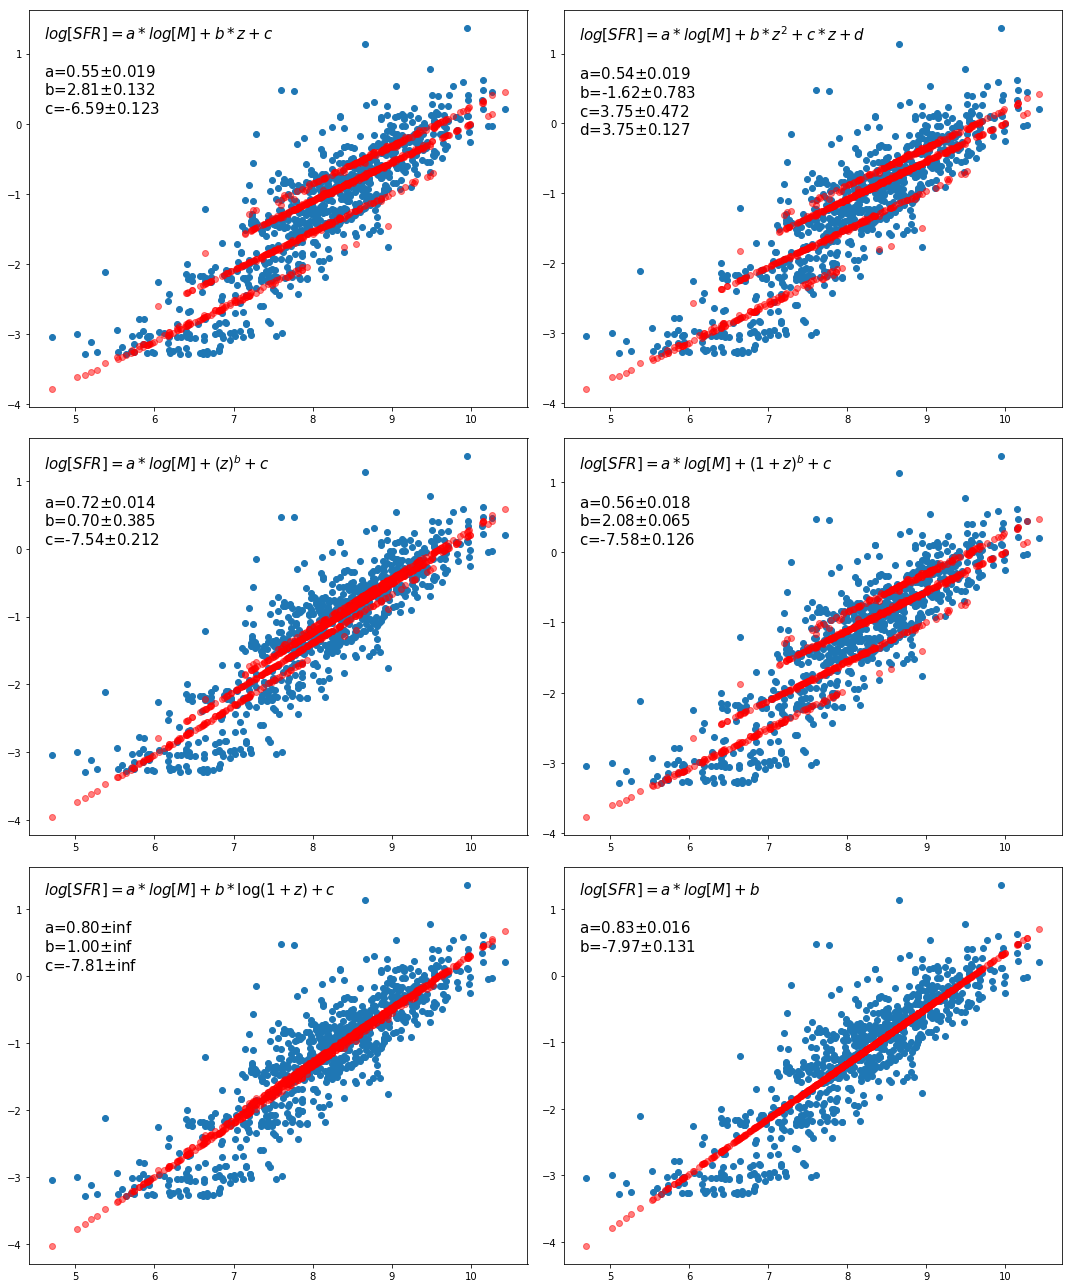

In [30]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## method='trf'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


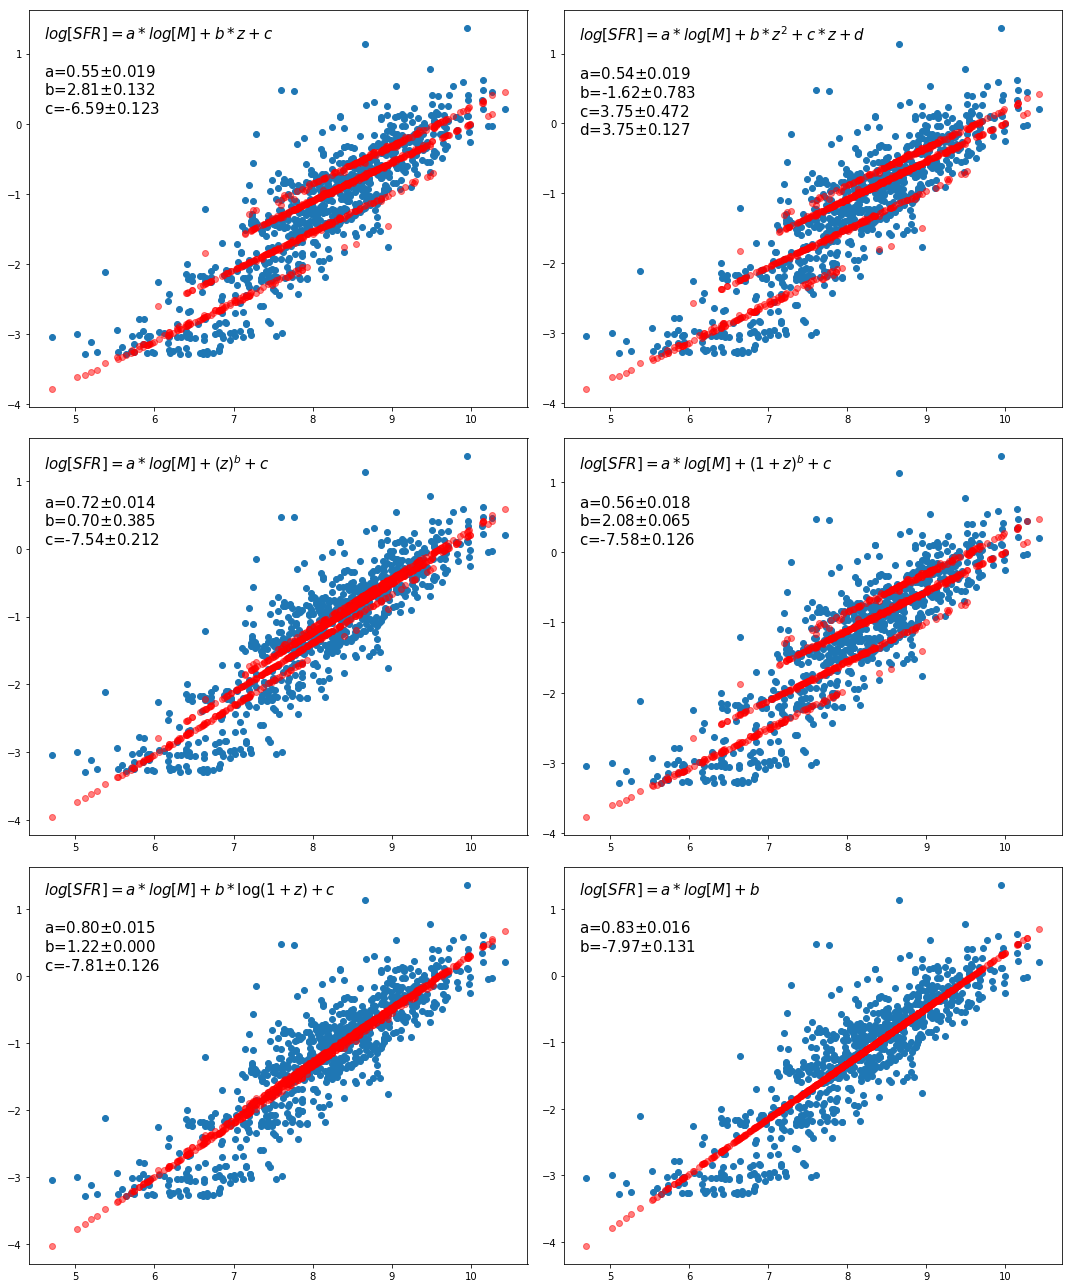

In [31]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')    
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## method='dogbox'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


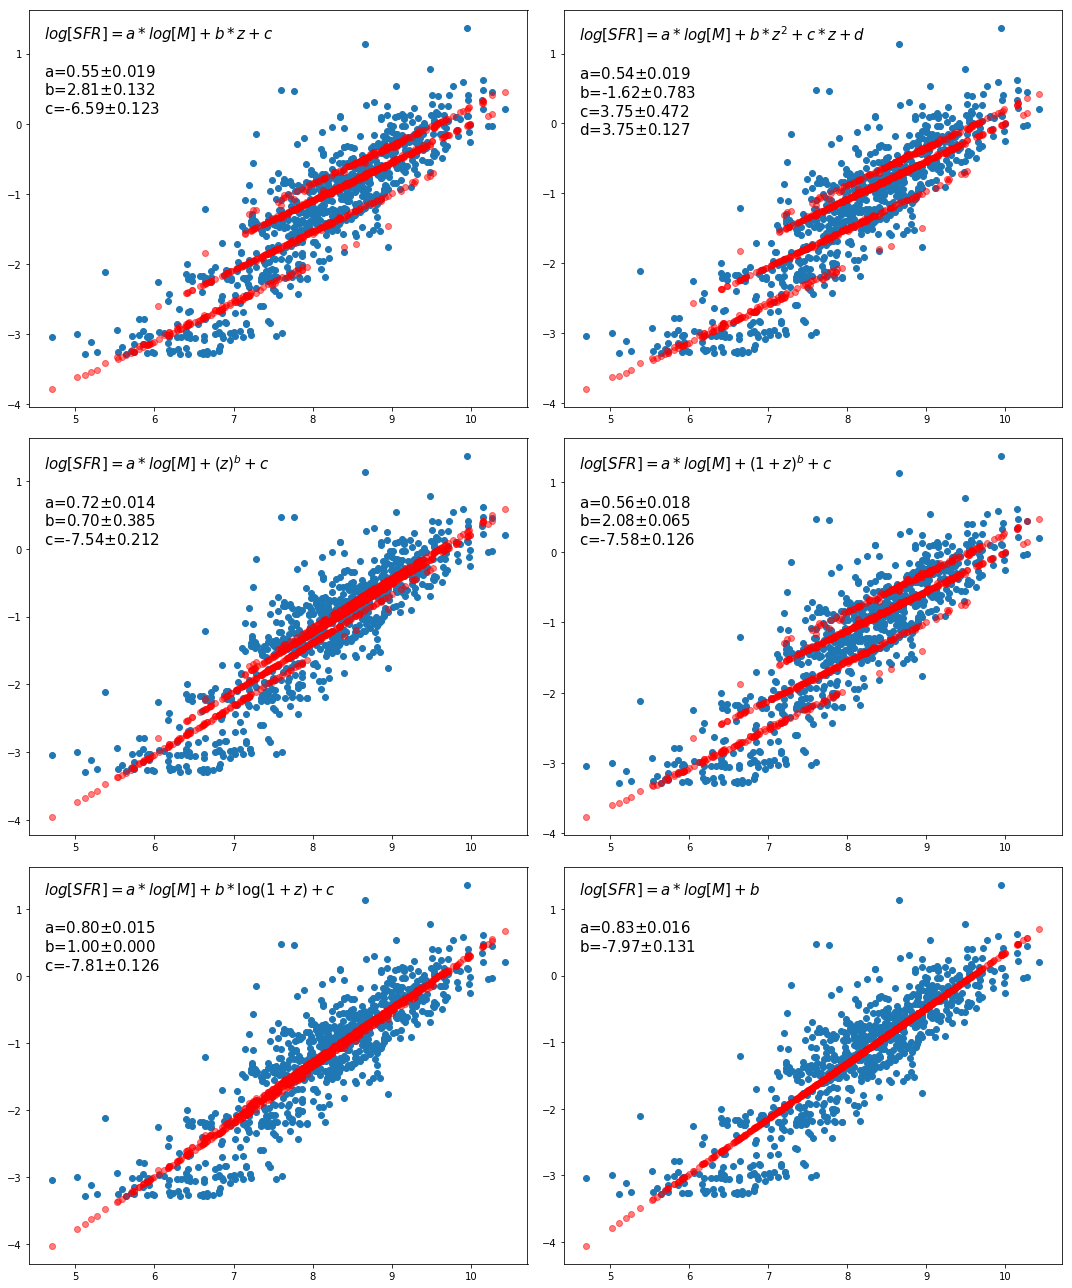

In [32]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    ax.plot(smass0, sfrs00, 'o')
    print eqn_str
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='dogbox')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, func(smass0, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

# residuals

## 'lm'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


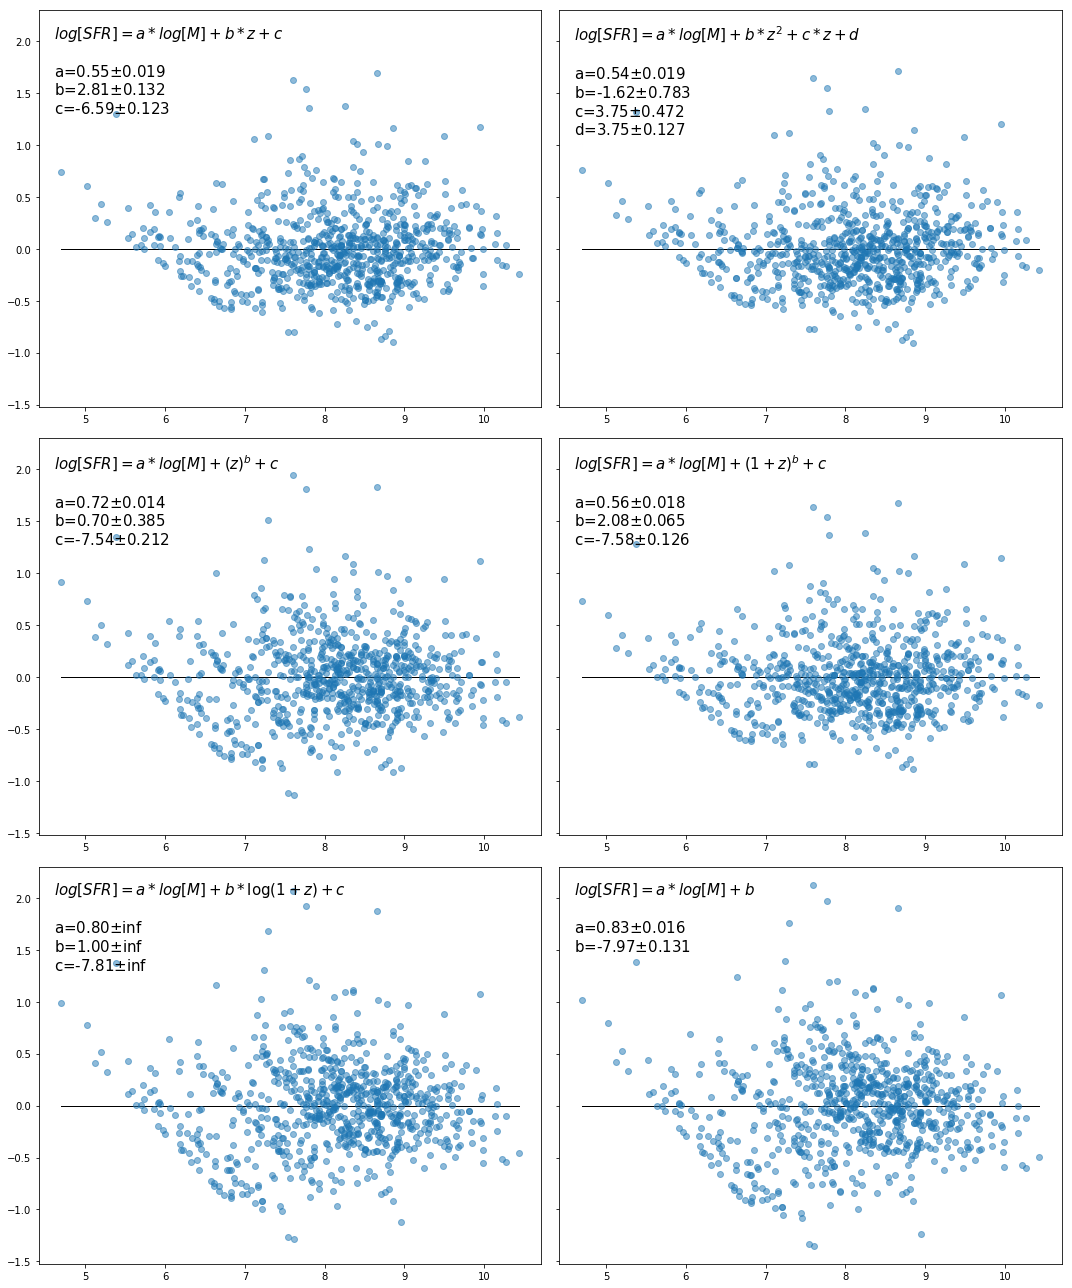

In [33]:
f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='lm')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(smass0, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

## trf

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


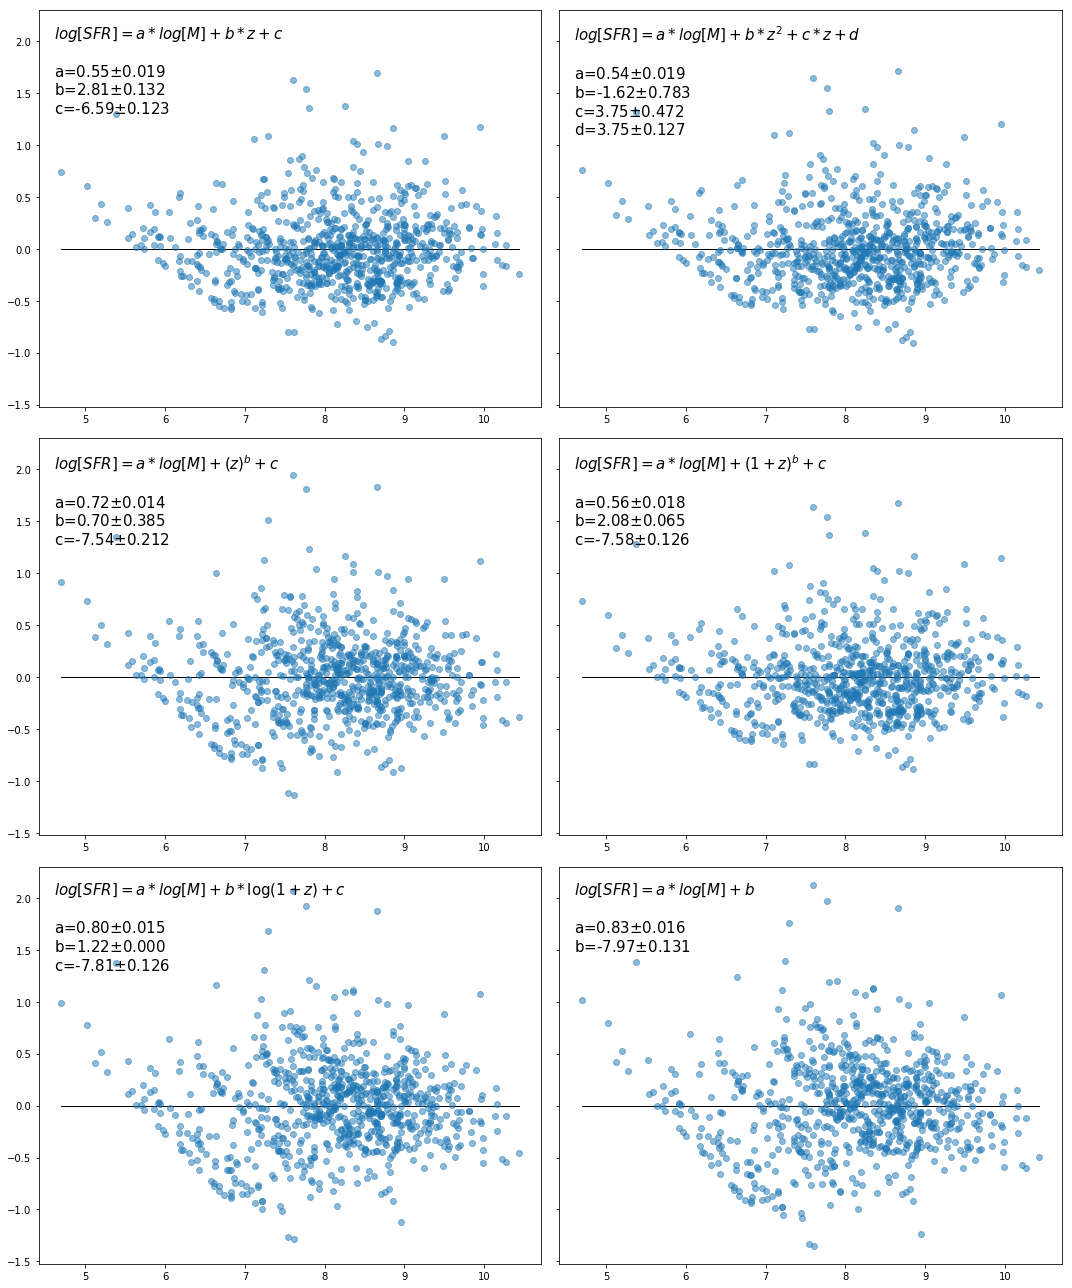

In [34]:
f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(data00, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        ax.plot(smass0, sfrs00 - func(smass0, *params), 'o', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    

f.set_size_inches(15,18)
f.tight_layout()

# rms

## trf

$log[SFR] = a*log[M] + b*z + c$
bin dispersion: 5.0 | 0.0
bin dispersion: 6.0 | 0.284814441111
bin dispersion: 7.0 | 0.292128197827
bin dispersion: 8.0 | 0.385606638299
bin dispersion: 9.0 | 0.352415253126
bin dispersion: 10.0 | 0.313934653619
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
bin dispersion: 5.0 | 0.0
bin dispersion: 6.0 | 0.282075126744
bin dispersion: 7.0 | 0.278573614084
bin dispersion: 8.0 | 0.388217303152
bin dispersion: 9.0 | 0.350752650553
bin dispersion: 10.0 | 0.308643836022
$log[SFR] = a*log[M] + (z)^{b} + c$
bin dispersion: 5.0 | 0.0
bin dispersion: 6.0 | 0.318413054439
bin dispersion: 7.0 | 0.38173726719
bin dispersion: 8.0 | 0.466693750375
bin dispersion: 9.0 | 0.357828100869
bin dispersion: 10.0 | 0.299085927204
$log[SFR] = a*log[M] + (1+z)^{b} + c$
bin dispersion: 5.0 | 0.0
bin dispersion: 6.0 | 0.28811376369
bin dispersion: 7.0 | 0.306982224147
bin dispersion: 8.0 | 0.386406362152
bin dispersion: 9.0 | 0.353228136081
bin dispersion: 10.0 | 0.316828896217
$log[SFR

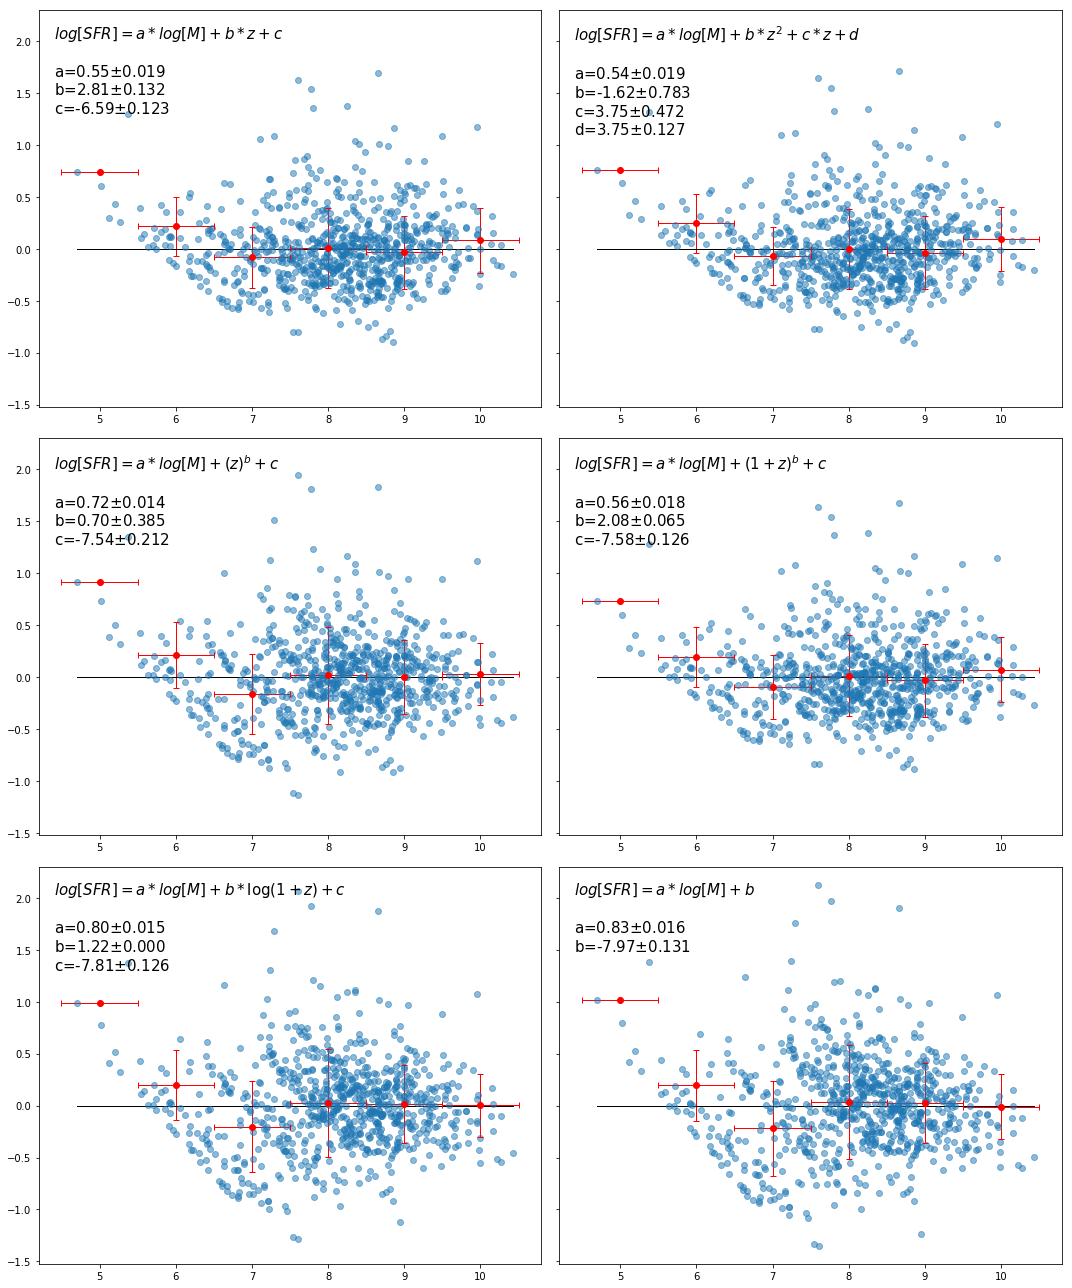

In [35]:
# min(smass0), max(smass0)
mbins0 = np.arange(4.5,11.5,1)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii

f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
    ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    
    for i in range(6):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ro')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='red')
        print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

### color coding by filter

In [36]:
filts99 = filts[good_sig_iis]
cwheel = [np.array(mpl.rcParams['axes.prop_cycle'])[x]['color'] for x in range(4)]

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


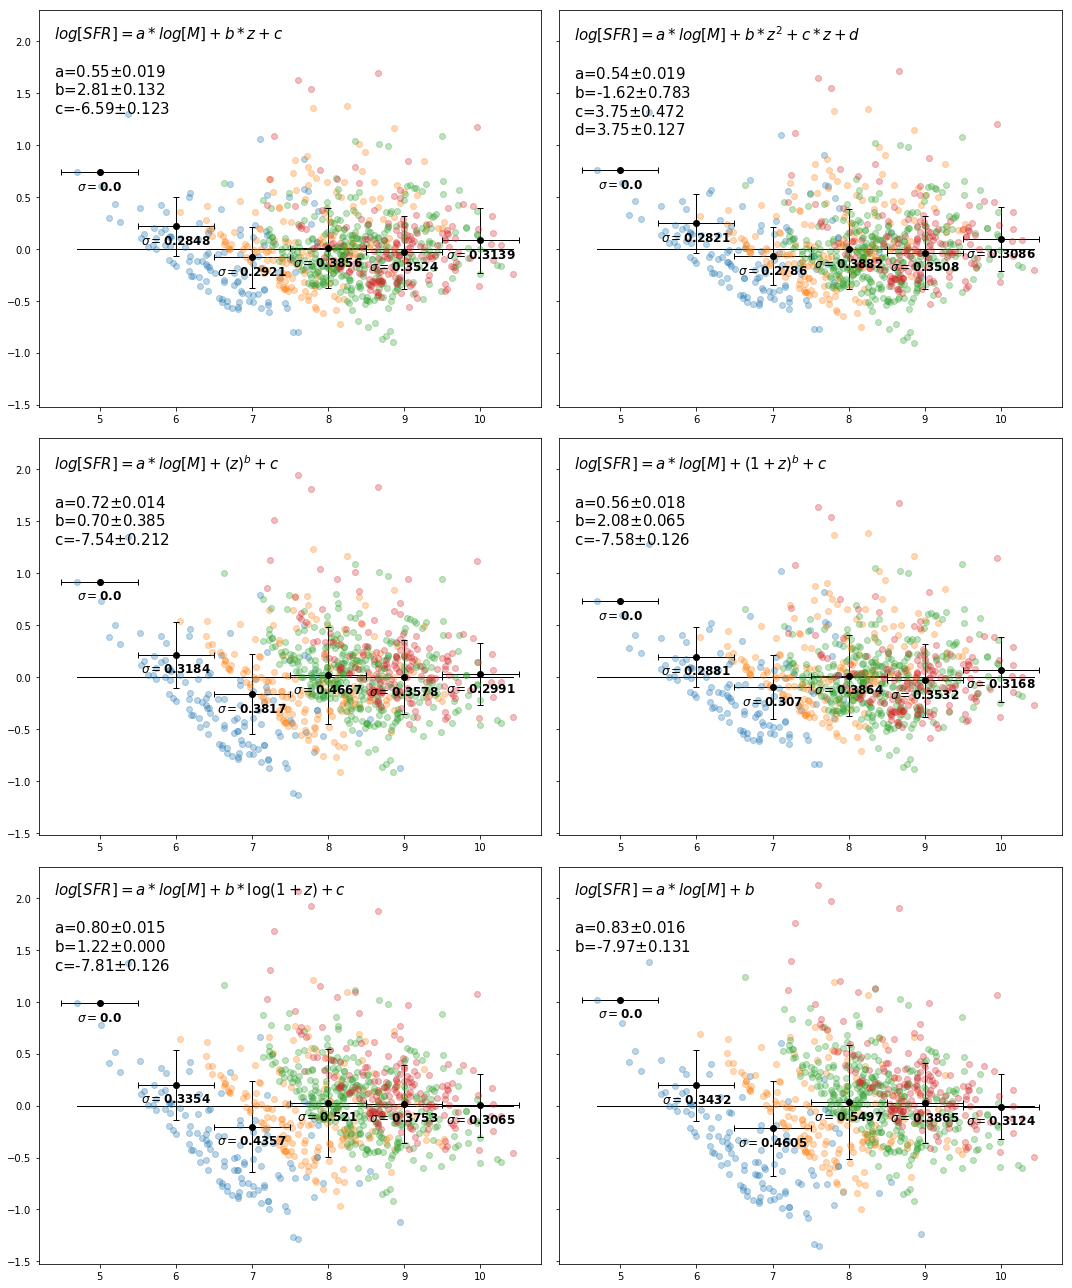

In [37]:
# min(smass0), max(smass0)
mbins0 = np.arange(4.5,11.5,1)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
#     ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)

#     plt.xlabel('M')
#     plt.ylabel('sigma_rms')
#     plt.legend(loc='best')
    
    for i in range(6):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ko')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbins[i], np.mean(sfrs_plot[bin_match])-0.2), 
                    va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
#         print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

### using integer edge bins

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$
$log[SFR] = a*log[M] + b$


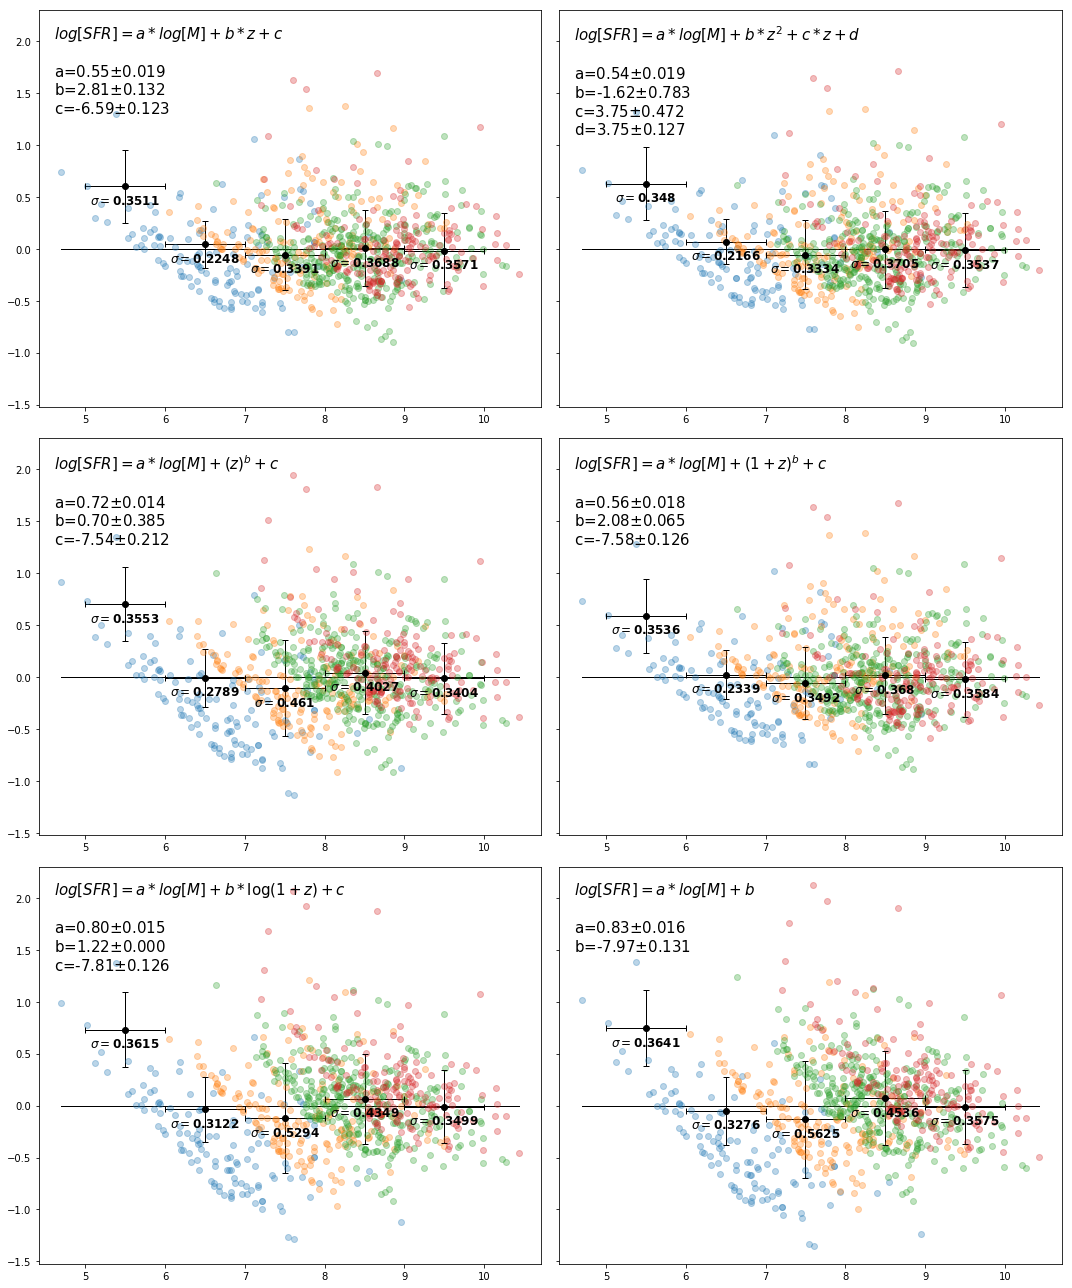

In [38]:
# min(smass0), max(smass0)
mbins0 = np.arange(5.0,11.0,1.0)
mbins = (mbins0+0.5)[:-1]
bin_ii = np.digitize(smass0, mbins)
# bin_ii


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
        
#     ax.plot(smass0, sfrs_plot, 'o', alpha=0.5)
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)

#     plt.xlabel('M')
#     plt.ylabel('sigma_rms')
#     plt.legend(loc='best')
    
    for i in range(5):
        bin_match = np.where(bin_ii == i)[0]
#         print np.mean(sfrs_plot[bin_match])
        ax.plot(mbins[i], np.mean(sfrs_plot[bin_match]), 'ko')
        ax.errorbar(mbins[i], np.mean(sfrs_plot[bin_match]), xerr=0.5, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbins[i], np.mean(sfrs_plot[bin_match])-0.2), 
                    va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
#         print 'bin dispersion:', mbins[i], '|', np.std(sfrs_plot[bin_match])

f.set_size_inches(15,18)
f.tight_layout()

### using quintile bins

$log[SFR] = a*log[M] + b*z + c$
sigma= 0.3401 	0.3931 	0.3277 	0.3716 	0.3085 	
===
$log[SFR] = a*log[M] + b*z^2 + c*z + d$
sigma= 0.3349 	0.3967 	0.3283 	0.3682 	0.3042 	
===
$log[SFR] = a*log[M] + (z)^{b} + c$
sigma= 0.4487 	0.4535 	0.3541 	0.351 	0.3107 	
===
$log[SFR] = a*log[M] + (1+z)^{b} + c$
sigma= 0.3493 	0.392 	0.3274 	0.3728 	0.3114 	
===
$log[SFR] = a*log[M] + b*\log(1+z) + c$
sigma= 0.5083 	0.4989 	0.3785 	0.3576 	0.3264 	
===
$log[SFR] = a*log[M] + b$
sigma= 0.537 	0.5238 	0.393 	0.3635 	0.3363 	
===
mean mass: 6.639 ('4.7', '7.35')
mean mass: 7.702 ('7.36', '7.98')
mean mass: 8.216 ('7.99', '8.43')
mean mass: 8.69 ('8.44', '8.93')
mean mass: 9.37 ('8.94', '10.43')


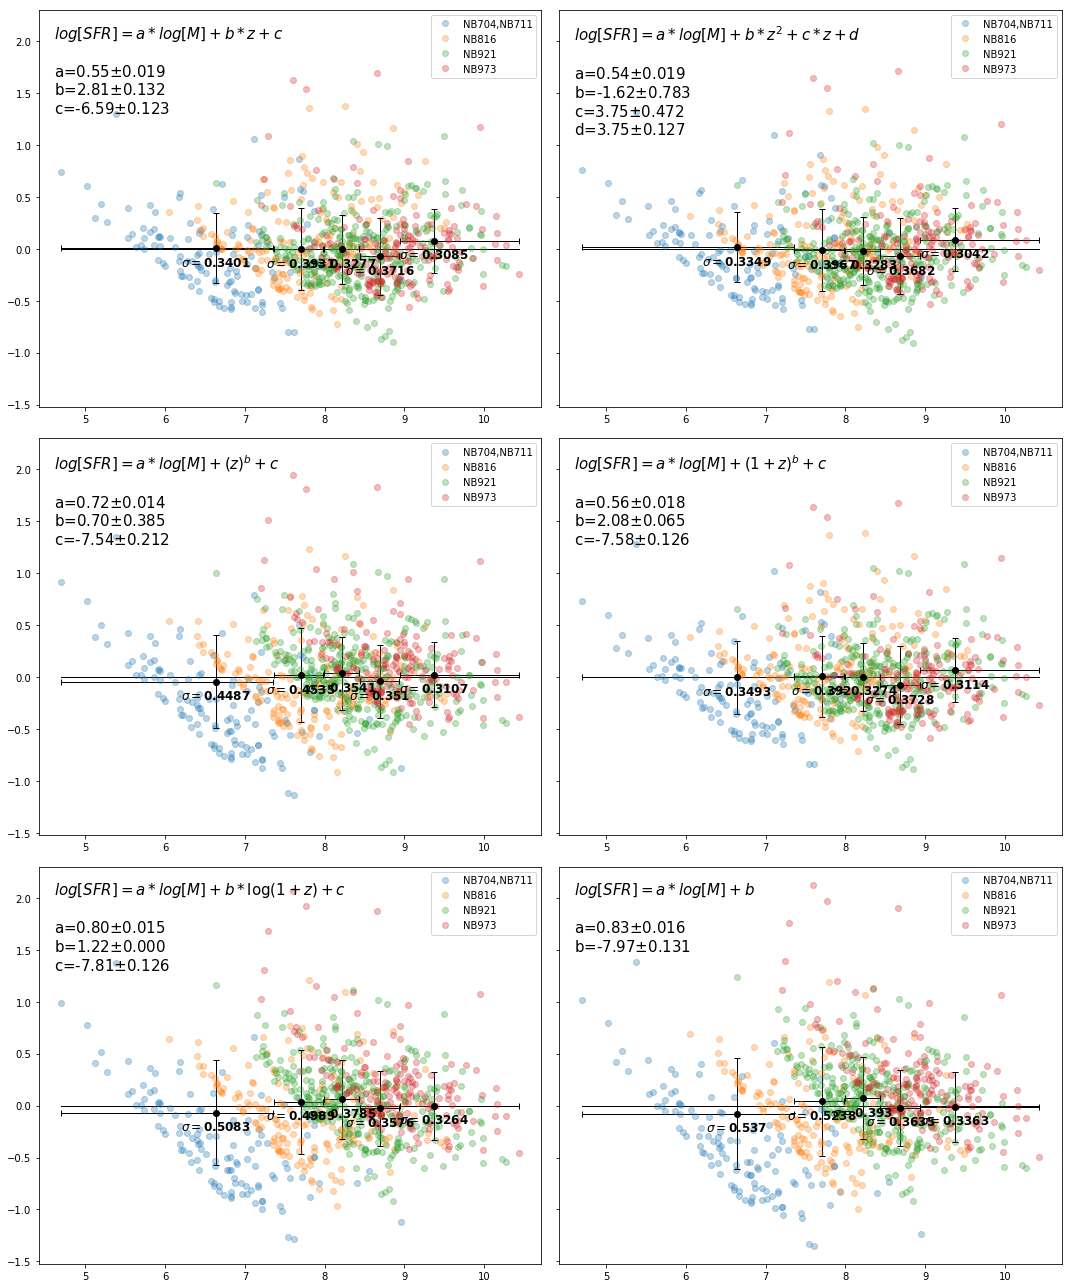

In [39]:
# quintile bins
perc20 = np.percentile(smass0, 20)
index_0 = np.array([x for x in range(len(smass0)) if (smass0[x]>0 and smass0[x]<=perc20)])

perc40 = np.percentile(smass0, 40)
index_1 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc20 and smass0[x]<=perc40)])

perc60 = np.percentile(smass0, 60)
index_2 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc40 and smass0[x]<=perc60)])

perc80 = np.percentile(smass0, 80)
index_3 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc60 and smass0[x]<=perc80)])

perc100 = np.percentile(smass0, 100)
index_4 = np.array([x for x in range(len(smass0)) if (smass0[x]>perc80 and smass0[x]<=perc100)])


f, axes = plt.subplots(3,2, sharey=True)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4, line], 
                             [eqn0, eqn1, eqn2, eqn3, eqn4, eqn5]):
    print eqn_str
    ax.plot(smass0, np.zeros(len(smass0)), 'k-')
    
    # fitting models and labeling subplots
    sfrs_plot = np.array([])
    if 'c' in eqn_str and 'd' not in eqn_str:   
        params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    elif 'd' in eqn_str:
        params, pcov = optimize.curve_fit(func, data00, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(data00, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2])+
            '\nd='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[3]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # no redshift dependence
        params, pcov = optimize.curve_fit(func, smass0, sfrs00, method='trf')
        perr = np.sqrt(np.diag(pcov))
        sfrs_plot = sfrs00 - func(smass0, *params)
        ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')

    # plotting data, color-coded by filter
    for ff,cc,ll in zip(['NB7', 'NB816', 'NB921', 'NB973'], cwheel, ['NB704,NB711', 'NB816', 'NB921', 'NB973']):
        filt_match = np.array([x for x in range(len(filts99)) if ff in filts99[x]])
        ax.plot(smass0[filt_match], sfrs_plot[filt_match], 'o', color=cc, alpha=0.3, label=ll)
#     if ax==axarr[0]:
    ax.legend(loc='best')


    # getting residuals (annotated) for binned data
    print 'sigma=',
    for bin_match in [index_0,index_1,index_2,index_3,index_4]:
        mbin = np.mean(smass0[bin_match])
        sfrbin = np.mean(sfrs_plot[bin_match])
        
        ax.plot(mbin, sfrbin, 'ko')
        xerr00=np.reshape([mbin - min(smass0[bin_match]), 
                           max(smass0[bin_match]) - mbin], (2,1))
        ax.errorbar(mbin, sfrbin, 
                    xerr=xerr00, yerr=np.std(sfrs_plot[bin_match]),
                    capsize=3, color='k')
        ax.annotate(#r'$\mu=$'+str(np.round(np.mean(smass0[bin_match]), 4))+'\n'+
                    r'$\sigma=$'+str(np.round(np.std(sfrs_plot[bin_match]), 4)), 
                    (mbin, sfrbin-0.2), va='bottom', ha='center', fontsize=12, color='k', fontweight='bold')
        print str(np.round(np.std(sfrs_plot[bin_match]), 4)), '\t',

    print '\n==='
        
for bin_match in [index_0,index_1,index_2,index_3,index_4]:
    print 'mean mass:', str(np.round(np.mean(smass0[bin_match]), 3)), (str(np.round(min(smass0[bin_match]),3)), str(np.round(max(smass0[bin_match]),3)))

f.set_size_inches(15,18)
f.tight_layout()

In [40]:
## next step:
# sfr vs stlr mass, include redshift dependence in the x axis

# new equation: 
# log[SFR] = a*log[m] + log(1+z) (second order?)

take total errors, remove systematic scatter, left with just intrinsic scatter (what we want)

.3 dex in total seen uncertainty, .1 dex in measurement uncertainty, subtract in quadrature to get intrinsic scatter = sqrt(.3^2 - .1^2)

(1) filter corrections (doing it as a constant), leave it alone
(2) nii corrections, made of composite measurements (uncertainties) -- propagate this through
(3) balmer decrement errors (if individual, do a monte carlo based on SNR to get errors -- chun has this code; get composite uncertainties) -- propagate this through

sum above to get total systematic errors for each galaxy

when you plot mainseq, get somewhere on the top, avg errs for each stlr mass (like, binned)


take a given sample at a given z, treat them all as the same, compute what the sSFR is. let's say for 0.5 it's -9. find it for the other redshift cases too.

think of that as the intercept (redshift-dependent). use that to translate to a functional form for the intercept, and when you do fitting, you fix those coeffs but allow the slope to vary.

In [45]:
ssfr = sfrs00/smass0

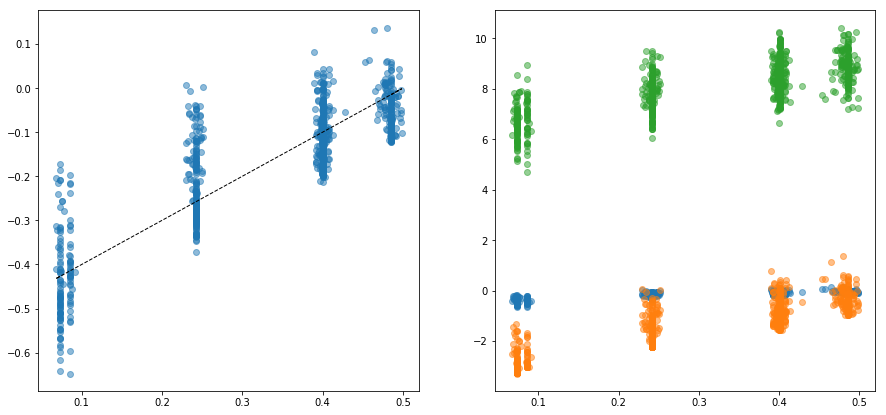

In [71]:
f, ax = plt.subplots(1,2)
ax[0].plot(zspec0, sfrs00/smass0, 'o', alpha=0.5)
ax[0].plot(zspec0, zspec0-.5, 'k--')

ax[1].plot(zspec0, sfrs00/smass0, 'o', alpha=0.5)
ax[1].plot(zspec0, sfrs00, 'o', alpha=0.5)
ax[1].plot(zspec0, smass0, 'o', alpha=0.5)

f.set_size_inches(15,7)

In [54]:
print np.std(sfrs00/smass0)

0.144809501584
